# Import all the dependencies


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


import warnings

warnings.filterwarnings("ignore")


sns.set_style("white")

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [ ]:
from signature_validation.plotting.plotting import (
    plot_waterfall,
    boxplot_with_pvalue_new,
    lin_colors,
    boxplot_with_pvalue,
)
from signature_validation.ssgsea_calc.ssgsea_calc import (
    read_gene_sets,
    ssgsea_formula,
    gmt_genes_alt_names,
)
from signature_validation.utils.utils import (
    read_dataset,
    process_generic_dataset,
    to_common_samples,
    median_scale,
)

# Read data

In [ ]:
emt_gmt = read_gene_sets("./data/emt_fges.gmt")

In [ ]:
pigm = pd.read_csv("./data/TCGA_Pigmentation_Score.csv", index_col=0)
pigm_long = pd.read_csv("./data/TCGA_Pigmentation_Score.csv", index_col=0)[
    "Pigmentation_Score"
]
skcm_expr = read_dataset("/internal_data/TCGA-SKCM/expressions.tsv.gz")
# Get TCGA expressions via GDC portal
skcm_expr = skcm_expr.T
skcm_expr.index = skcm_expr.index.map(lambda x: x[:-3])
skcm_expr = skcm_expr[~skcm_expr.index.duplicated()]
skcm_anno = read_dataset("./data/TCGA-SKCM_annotation.tsv")
skcm_anno.index = skcm_anno.index.map(lambda x: x[:-3])
skcm_anno = skcm_anno[~skcm_anno.index.duplicated()]
pigm[pigm.isin([0])] = "Low_Pigment"
pigm[pigm.isin([1, 2, 3])] = "High_Pigment"
df_pigm = ssgsea_formula(skcm_expr.T, gmt_genes_alt_names(emt_gmt, skcm_expr.columns))
df_pigm = df_pigm.T

/tmp/ipykernel_797/1499322116.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Low_Pigment' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pigm[pigm.isin([0])] = 'Low_Pigment'


In [9]:
pigm.reindex(df_pigm.index).dropna()

,Pigmentation_Score
TCGA-FW-A3I3,Low_Pigment
TCGA-FS-A1ZD,Low_Pigment
TCGA-EE-A2M6,High_Pigment
TCGA-FS-A4FD,Low_Pigment
TCGA-EE-A3AD,Low_Pigment
...,...
TCGA-EE-A20C,Low_Pigment
TCGA-EB-A4OZ,High_Pigment
TCGA-EE-A2MR,Low_Pigment
TCGA-EE-A3J4,Low_Pigment


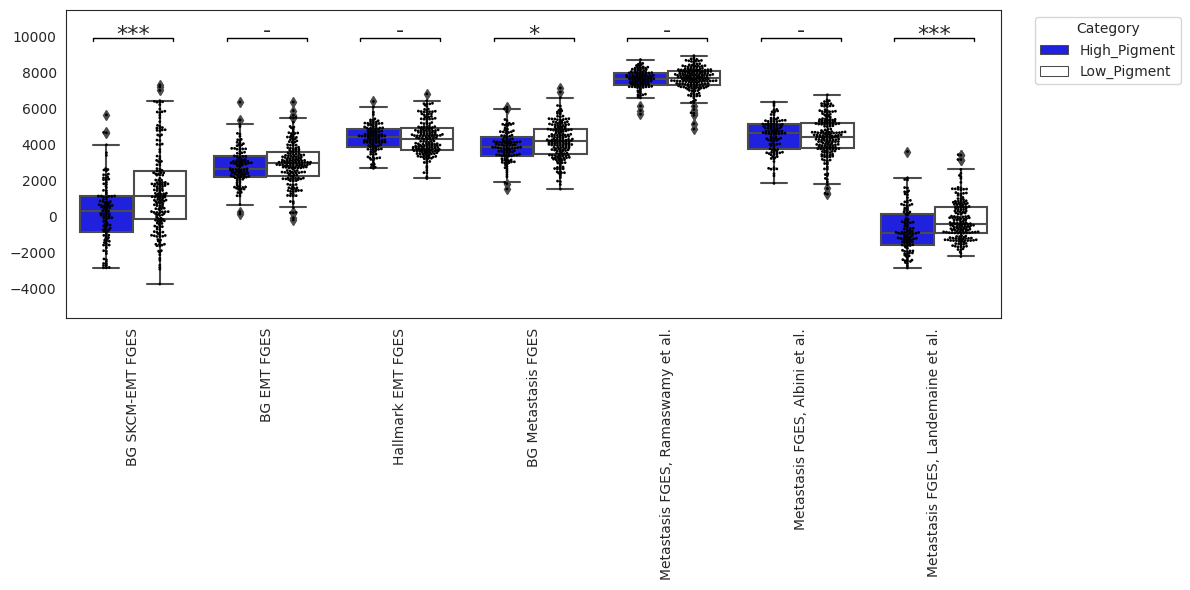

In [ ]:
out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_pigm, pigm.Pigmentation_Score
)
order = [
    "BG SKCM-EMT FGES",
    "BG EMT FGES",
    "Hallmark EMT FGES",
    "BG Metastasis FGES",
    "Metastasis FGES, Ramaswamy et al.",
    "Metastasis FGES, Albini et al.",
    "Metastasis FGES, Landemaine et al.",
]
palette = {"Low_Pigment": "white", "High_Pigment": "blue"}
data = df_pigm.copy()[order]
grouping = pigm.Pigmentation_Score.copy()
p_values = out_mw_corrected.T.iloc[0].copy().loc[order]

data, grouping = to_common_samples((data, grouping))

numeric = pd.concat(
    [
        pd.Series(data=data[x].values, index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)
grouping = pd.concat(
    [
        pd.Series(data=grouping.values, index=grouping.index.map(lambda i: f"{i}_{x}"))
        for x in order
    ]
)
signs = pd.concat(
    [
        pd.Series(data=[x] * len(data), index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)

boxplot_with_pvalue_new(
    data=numeric,
    categories=grouping,
    pvalues=p_values,
    columns_list=order,
    signs=signs,
    palette=palette,
)
plt.tight_layout()
plt.savefig(
    "./plots/pigm_boxplots.svg",
    format="svg",
)

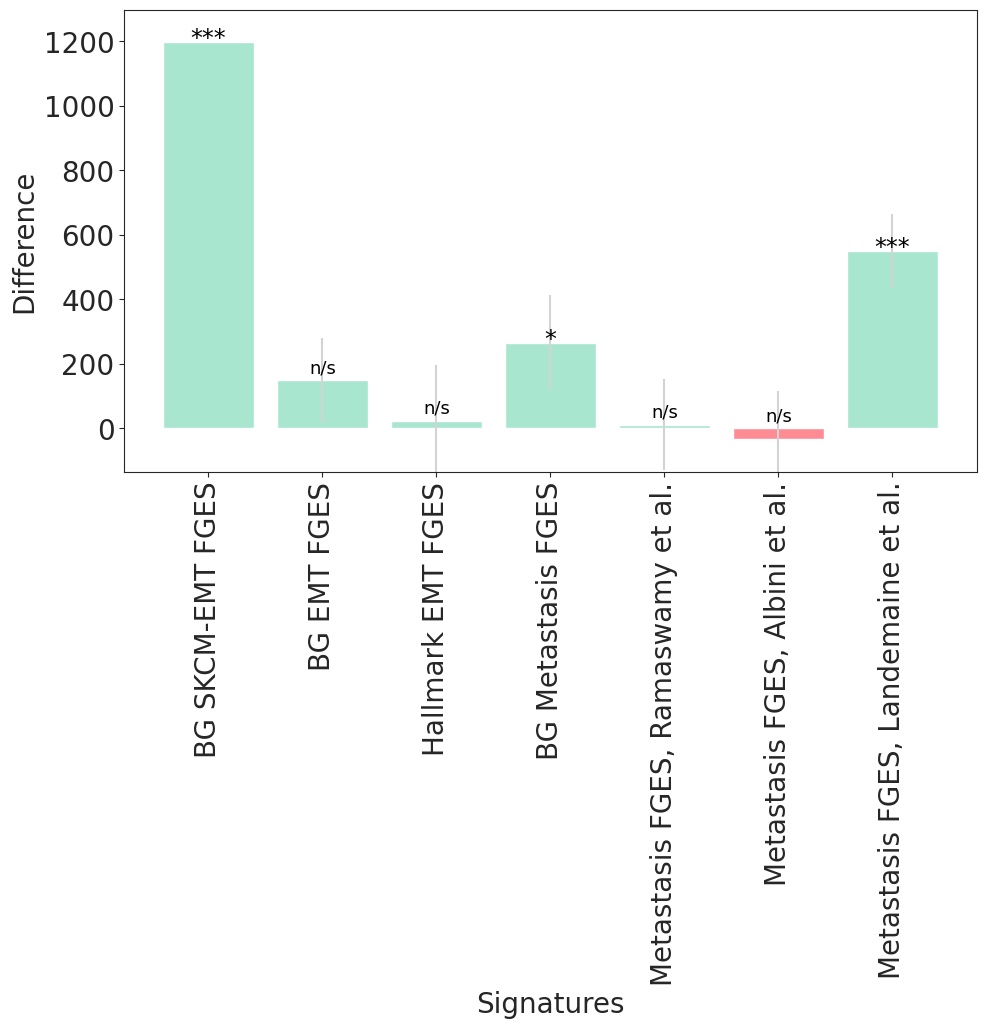

In [ ]:
out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_pigm, pigm.Pigmentation_Score
)
plot_waterfall(
    out,
    out_mw_corrected,
    out_stdev,
    main_column="Low_Pigment",
    path_to_save="./plots/pigm_waterfall.svg",
    sort_by_list=order,
)

In [ ]:
expr_br = read_dataset("./data/GSE48091_GPL10379_source_not_raw_max_gs_samples.tsv")
anno_br = read_dataset("./data/GSE48091_common_annotation.tsv")
for i in anno_br["characteristics_ch1.setnr"].index:
    if len(anno_br["characteristics_ch1.setnr"].loc[i]) > 4:
        anno_br["characteristics_ch1.setnr"].loc[i] = int(
            anno_br["characteristics_ch1.setnr"].loc[i].split(",")[0]
        )
    else:
        anno_br["characteristics_ch1.setnr"].loc[i] = int(
            anno_br["characteristics_ch1.setnr"].loc[i]
        )
anno_br["risk_sets"] = anno_br["characteristics_ch1.setnr"]
anno_br["risk_sets"][anno_br["characteristics_ch1.setnr"] < 2000] = 1
anno_br["risk_sets"][anno_br["characteristics_ch1.setnr"] > 3000] = 3
anno_br["risk_sets"][~anno_br["risk_sets"].isin([1, 3])] = 2
for i in anno_br["characteristics_ch1.case-control status"].index:
    if len(anno_br["characteristics_ch1.case-control status"].loc[i]) > 1:
        anno_br["characteristics_ch1.case-control status"].loc[i] = sum(
            [
                int(x)
                for x in anno_br["characteristics_ch1.case-control status"]
                .loc[i]
                .split(",")
            ]
        )
    else:
        anno_br["characteristics_ch1.case-control status"].loc[i] = int(
            anno_br["characteristics_ch1.case-control status"].loc[i]
        )
anno_br["metastasis_status"] = anno_br["characteristics_ch1.case-control status"]
df_br = ssgsea_formula(expr_br, gmt_genes_alt_names(emt_gmt, expr_br.index)).T

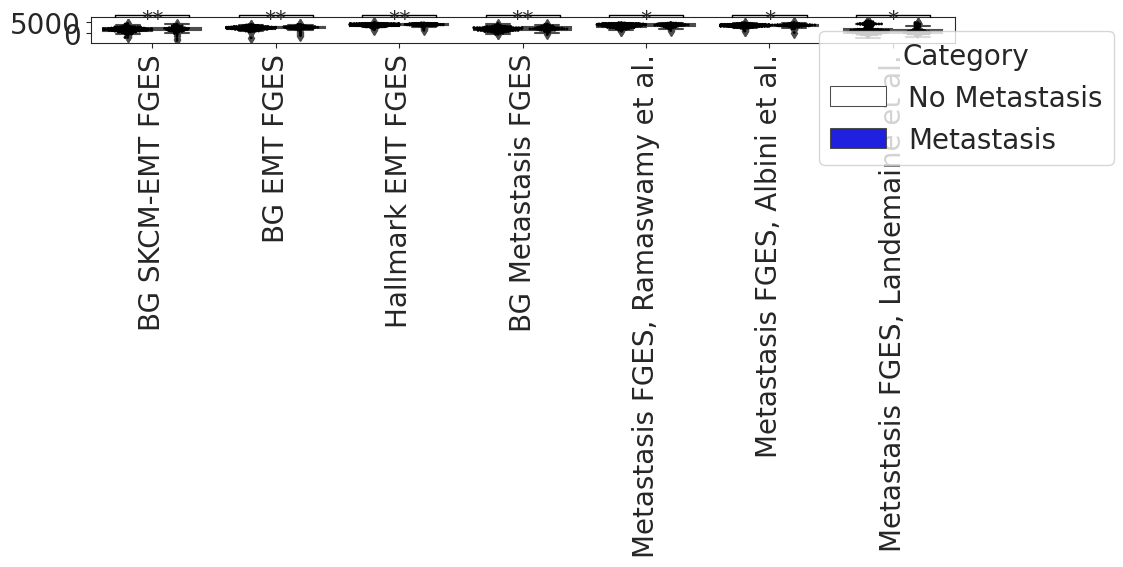

In [ ]:
palette = {"No Metastasis": "white", "Metastasis": "blue"}
data = df_br.copy()[order]
grouping = anno_br["metastasis_status"].map(
    lambda x: "No Metastasis" if x == 0 else "Metastasis"
)
p_values = out_mw_corrected.T.iloc[0].copy().loc[order]

data, grouping = to_common_samples((data, grouping))

numeric = pd.concat(
    [
        pd.Series(data=data[x].values, index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)
grouping = pd.concat(
    [
        pd.Series(data=grouping.values, index=grouping.index.map(lambda i: f"{i}_{x}"))
        for x in order
    ]
)
signs = pd.concat(
    [
        pd.Series(data=[x] * len(data), index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)

boxplot_with_pvalue_new(
    data=numeric,
    categories=grouping,
    pvalues=p_values,
    columns_list=order,
    signs=signs,
    palette=palette,
)
plt.tight_layout()
plt.savefig(
    "./plots/met_br_boxplots.svg",
    format="svg",
)

In [6]:
df_pigm_sc = median_scale(df_pigm)
df_br_sc = median_scale(df_br)

In [7]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'

sns.set_style('ticks')
sns.axes_style('white')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'grid.color': '.8',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

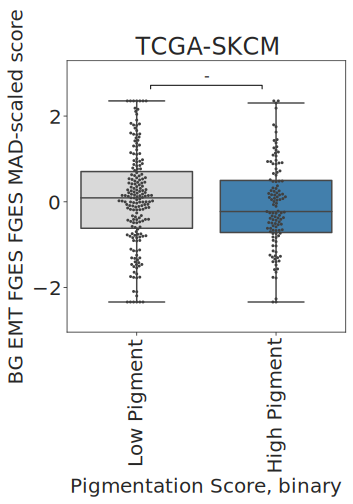

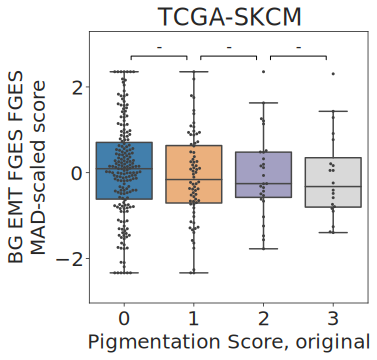

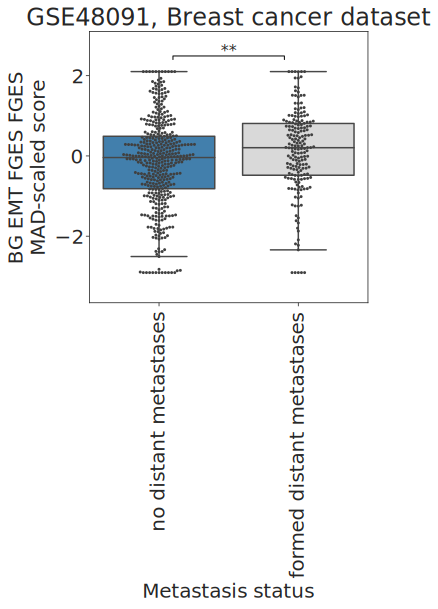

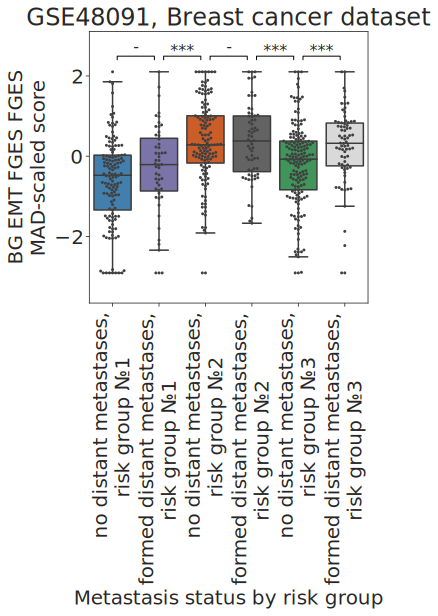

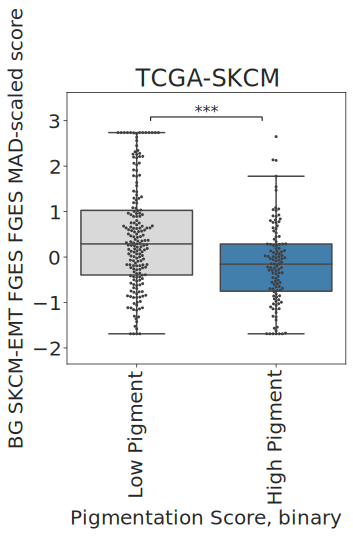

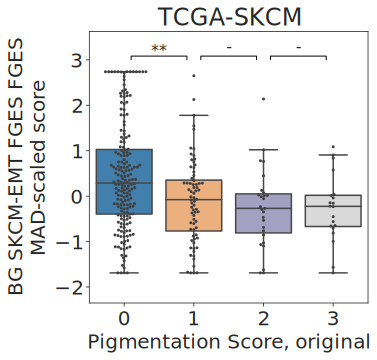

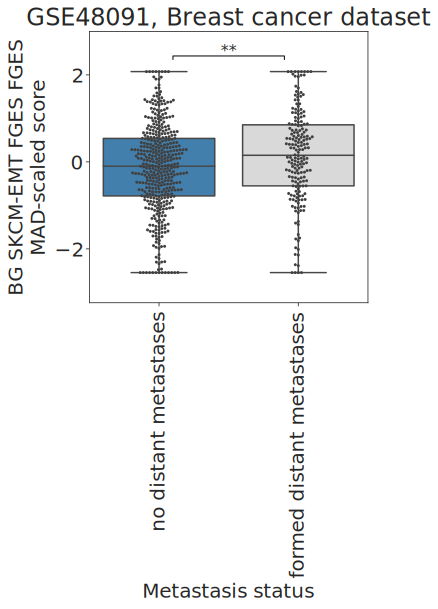

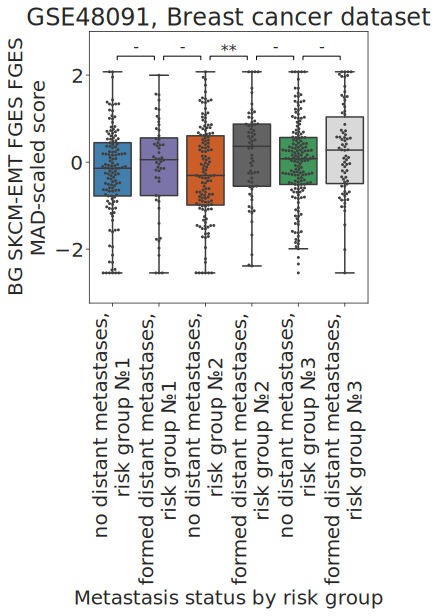

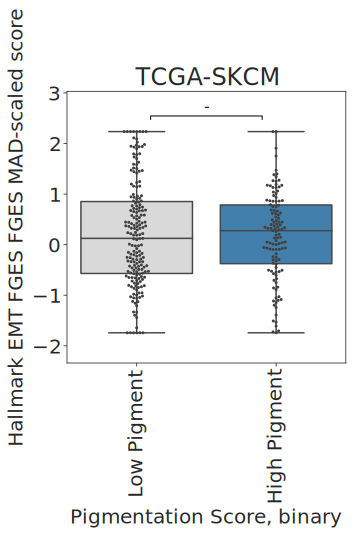

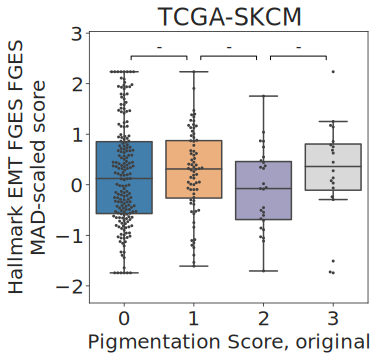

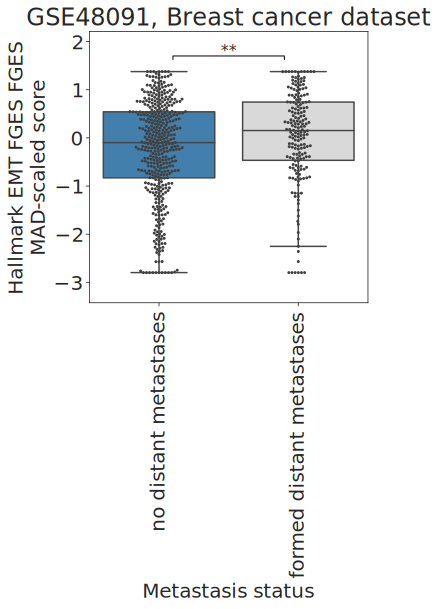

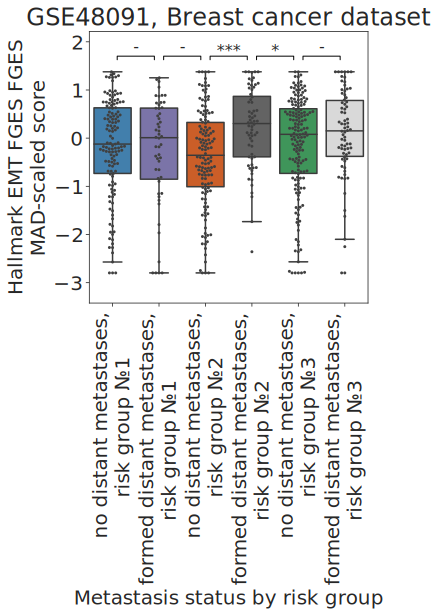

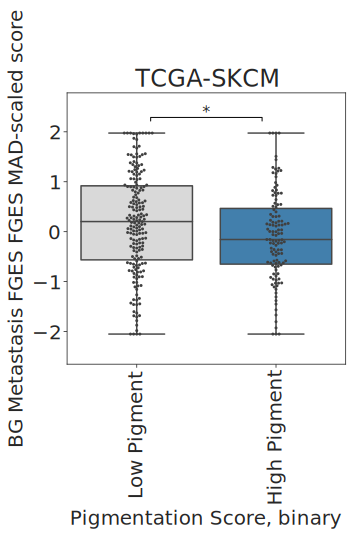

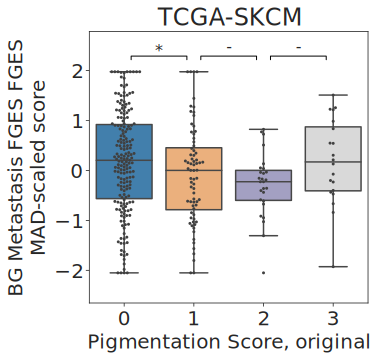

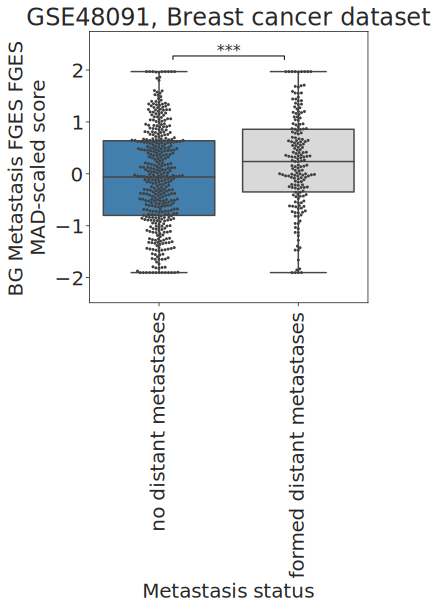

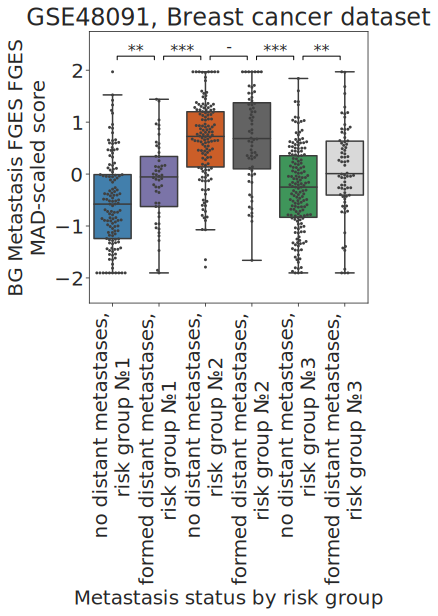

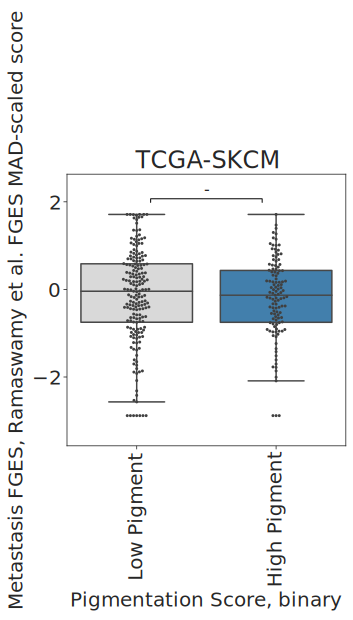

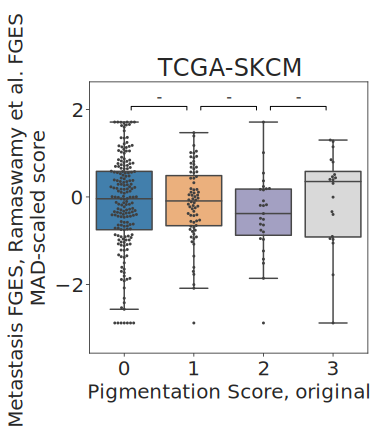

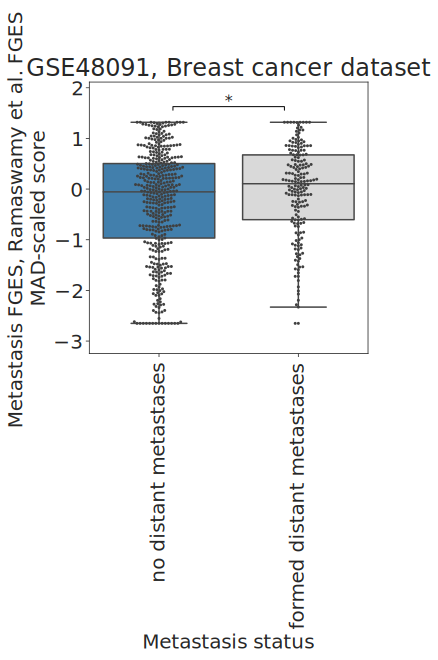

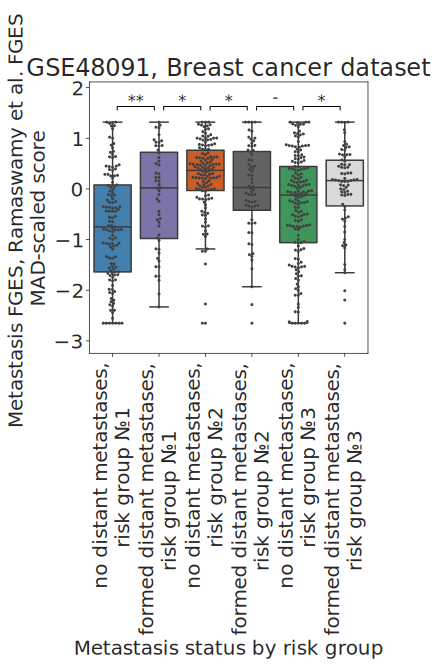

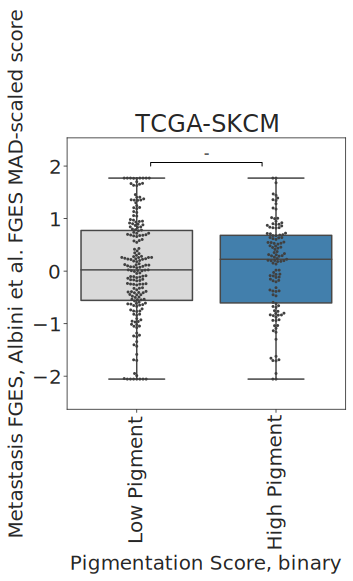

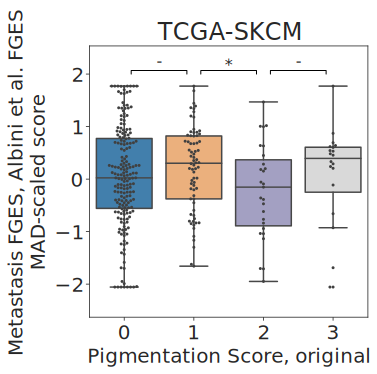

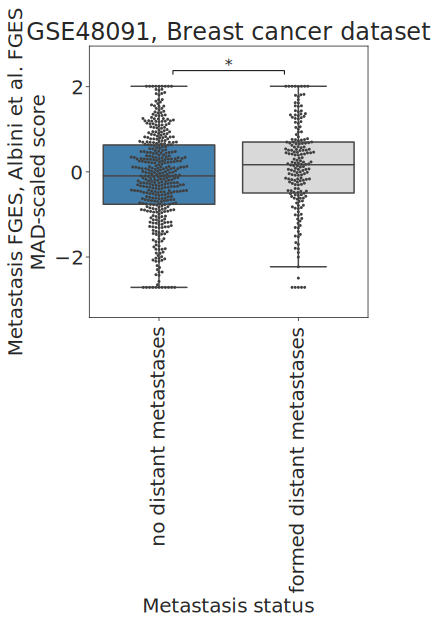

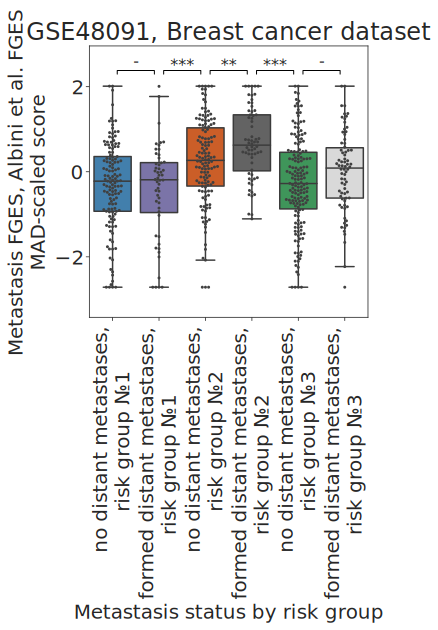

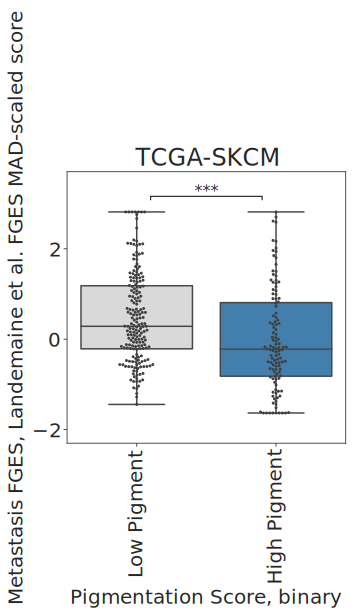

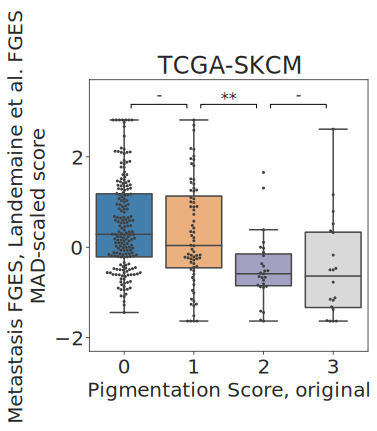

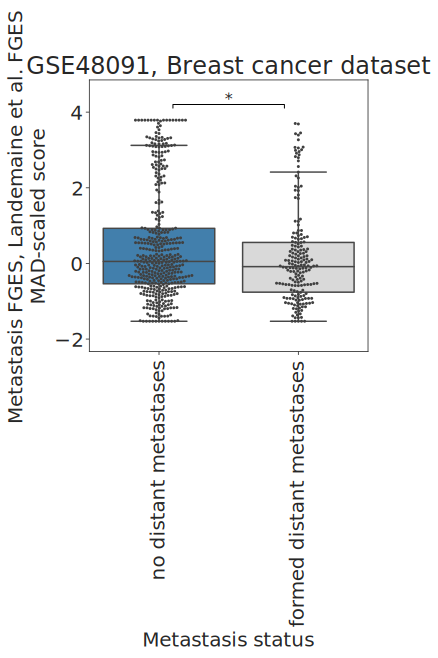

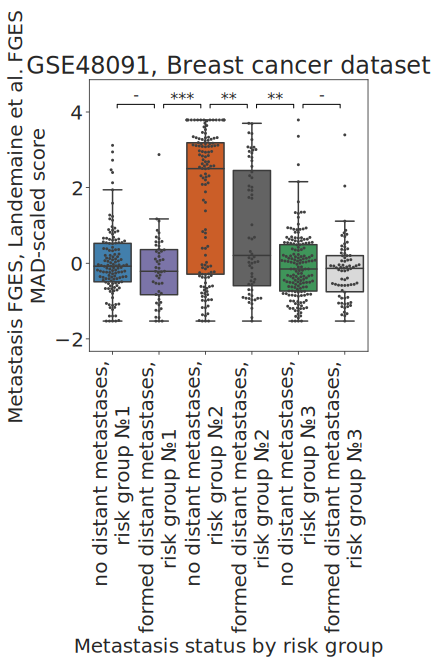

In [ ]:
sns.set_style("ticks")
for sign in emt_gmt.keys():
    title = sign.replace("Main4_", "").replace("_", " ") + " FGES"
    fig, ax = plt.subplots(figsize=(5, 5))
    pal = lin_colors(pigm["Pigmentation_Score"], cmap=matplotlib.colormaps["tab20c"])
    order = ["Low_Pigment", "High_Pigment"]
    boxplot_with_pvalue(
        df_pigm_sc[sign].clip(
            df_pigm_sc[sign].quantile(0.025), df_pigm_sc[sign].quantile(0.975)
        ),
        pigm["Pigmentation_Score"],
        order=order,
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xlabel("Pigmentation Score, binary")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES MAD-scaled score"
    )
    ax.set_title("TCGA-SKCM")
    ax.set_xticklabels([i.replace("_", " ") for i in order], rotation=90)
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_TCGA-SKCM_Pigmentation Score, binary.svg".replace(" ", "_")
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()
    fig, ax = plt.subplots(figsize=(5, 5))
    pal = lin_colors(pigm_long, cmap=matplotlib.colormaps["tab20c"])
    boxplot_with_pvalue(
        df_pigm_sc[sign].clip(
            df_pigm_sc[sign].quantile(0.025), df_pigm_sc[sign].quantile(0.975)
        ),
        pigm_long,
        order=[0, 1, 2, 3],
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xlabel("Pigmentation Score, original")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES\nMAD-scaled score"
    )
    ax.set_title("TCGA-SKCM")
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_TCGA-SKCM_Pigmentation Score, original.svg".replace(" ", "_")
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()
    fig, ax = plt.subplots(figsize=(5, 5))
    pal = lin_colors(anno_br["metastasis_status"], cmap=matplotlib.colormaps["tab20c"])
    boxplot_with_pvalue(
        df_br_sc[sign].clip(
            df_br_sc[sign].quantile(0.025), df_br_sc[sign].quantile(0.975)
        ),
        anno_br["metastasis_status"],
        order=[0, 1],
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xticklabels(
        ["no distant metastases", "formed distant metastases"], rotation=90
    )
    ax.set_xlabel("Metastasis status")
    ax.set_title("GSE48091, Breast cancer dataset")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES\nMAD-scaled score"
    )
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_GSE48091, Breast cancer dataset_Metastasis status.svg".replace(
            " ", "_"
        )
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()
    fig, ax = plt.subplots(figsize=(5, 5))
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    pal = lin_colors(ser, cmap=matplotlib.colormaps["tab20c"])
    order = [
        "metastasis 0, risk 1",
        "metastasis 1, risk 1",
        "metastasis 0, risk 2",
        "metastasis 1, risk 2",
        "metastasis 0, risk 3",
        "metastasis 1, risk 3",
    ]
    boxplot_with_pvalue(
        df_br_sc[sign].clip(
            df_br_sc[sign].quantile(0.025), df_br_sc[sign].quantile(0.975)
        ),
        ser,
        order=order,
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xlabel("Metastasis status by risk group")
    ax.set_xticklabels(
        [
            i.replace("metastasis 0,", "no distant metastases,\n")
            .replace("metastasis 1,", "formed distant metastases,\n")
            .replace("risk ", "risk group №")
            for i in order
        ],
        rotation=90,
    )
    ax.set_title("GSE48091, Breast cancer dataset")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES\nMAD-scaled score"
    )
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_GSE48091, Breast cancer dataset_Metastasis status by risk group.svg".replace(
            " ", "_"
        )
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()

In [36]:
f"boxplots/{title}_TCGA-SKCM_Pigmentation Score, binary"

'boxplots/Metastasis_FGES_Ramaswamy_et_al_FGES_TCGA_SKCM_Pigmentation_Score_binary'

## Heatmap

In [ ]:
out = {sign: {} for sign in emt_gmt.keys()}
for sign in emt_gmt.keys():
    out[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .mean(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .mean(),
    }
    # out[sign]['Pigm Score, long'] = {'Low':df_pigm[sign].reindex(pigm_long[pigm_long==0].index).dropna().mean(),
    #                                  'Medlow':df_pigm[sign].reindex(pigm_long[pigm_long==1].index).dropna().mean(),
    #                                 'Medhigh':df_pigm[sign].reindex(pigm_long[pigm_long==2].index).dropna().mean(),
    #                                  'High':df_pigm[sign].reindex(pigm_long[pigm_long==3].index).dropna().mean(),}
    # out[sign]['Breast Metastasis, w/o risks'] = {'No metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==0].index).dropna().mean(),
    #                                  'Metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==1].index).dropna().mean(),
    #                                 }
    # ser = anno_br['metastasis_status'].map(lambda x:f'metastasis {x}, ')+anno_br['risk_sets'].map(lambda x:f'risk {x}')
    # out[sign]['Breast Metastasis, w risks'] = {x:df_br[sign].reindex(ser[ser==x].index).dropna().mean() for x in [ 'metastasis 0, risk 1', 'metastasis 1, risk 1', 'metastasis 0, risk 2',
    #    'metastasis 1, risk 2','metastasis 0, risk 3', 'metastasis 1, risk 3', ]}

In [ ]:
pd.DataFrame(out[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    # 'Pigm Score, long',
    #  'Breast Metastasis, w/o risks',
    # 'Breast Metastasis, w risks'
]
tables = {col: {sign: None for sign in out.keys()} for col in cols}
for sign in out.keys():
    for col in cols:
        tables[col][sign] = pd.DataFrame(out[sign])[col]

In [ ]:
out, out_stdev, out_mw = process_generic_dataset(
    df_scores, df_metadata, "GroupColumn", "BG EMT FGES"
)

In [ ]:
out_stdev = {sign: {} for sign in emg_gmt.keys()}
for sign in emt_gmt.keys():
    out_stdev[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .std(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .std(),
    }
    # out_stdev[sign]['Pigm Score, long'] = {'Low':df_pigm[sign].reindex(pigm_long[pigm_long==0].index).dropna().std(),
    #                                  'Medlow':df_pigm[sign].reindex(pigm_long[pigm_long==1].index).dropna().std(),
    #                                 'Medhigh':df_pigm[sign].reindex(pigm_long[pigm_long==2].index).dropna().std(),
    #                                  'High':df_pigm[sign].reindex(pigm_long[pigm_long==3].index).dropna().std(),}
    # out_stdev[sign]['Breast Metastasis, w/o risks'] = {'No metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==0].index).dropna().std(),
    #                                  'Metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==1].index).dropna().std(),
    #                                 }
    # ser = anno_br['metastasis_status'].map(lambda x:f'metastasis {x}, ')+anno_br['risk_sets'].map(lambda x:f'risk {x}')
    # out_stdev[sign]['Breast Metastasis, w risks'] = {x:df_br[sign].reindex(ser[ser==x].index).dropna().std() for x in [ 'metastasis 0, risk 1', 'metastasis 1, risk 1', 'metastasis 0, risk 2',
    #    'metastasis 1, risk 2','metastasis 0, risk 3', 'metastasis 1, risk 3', ]}

In [ ]:
pd.DataFrame(out_stdev[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    #  'Pigm Score, long', 'Breast Metastasis, w/o risks',
    # 'Breast Metastasis, w risks'
]
tables_stdev = {col: {sign: None for sign in out_stdev.keys()} for col in cols}
for sign in out_stdev.keys():
    for col in cols:
        tables_stdev[col][sign] = pd.DataFrame(out_stdev[sign])[col]

In [ ]:
out_mw = {sign: {} for sign in emt_gmt.keys()}
for sign in emt_gmt.keys():
    _, pv = mannwhitneyu(
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna(),
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna(),
        alternative="two-sided",
    )
    out_mw[sign]["Pigm Score, short"] = pv
    # _, pv = mannwhitneyu(df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==1].index).dropna(),
    #                                                      df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==0].index).dropna(),
    #                                                     alternative='two-sided')
    # out_mw[sign]['Breast Metastasis, w/o risks'] = pv

    # riskgroup = 3
    # ser = anno_br['metastasis_status'].map(lambda x:f'metastasis {x}, ')+anno_br['risk_sets'].map(lambda x:f'risk {x}')
    # a = df_br[sign].reindex(ser[ser==f'metastasis 0, risk {riskgroup}'].index).dropna()
    # b = df_br[sign].reindex(ser[ser==f'metastasis 1, risk {riskgroup}'].index).dropna()
    # _, pv = mannwhitneyu(a, b, alternative='two-sided')
    # out_mw[sign]['Breast Metastasis, w risks'] = pv

In [ ]:
out_mw = pd.DataFrame(out_mw)
for i in out_mw.index:
    _, out_mw.loc[i], _, _ = multipletests(out_mw.loc[i], method="fdr_bh")

In [ ]:
out_mw_corrected.loc["BG EMT FGES"][0]

0.011176285349305278

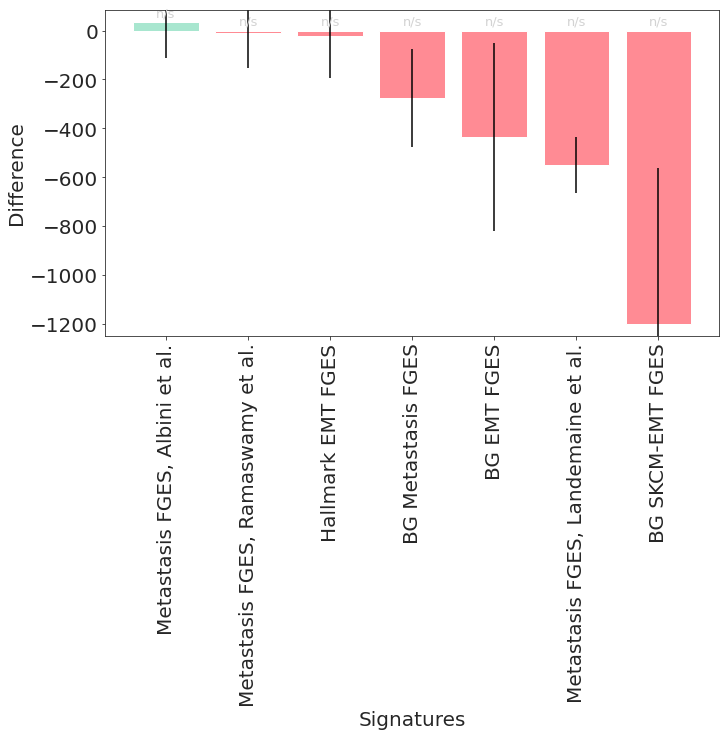

In [ ]:
out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_pigm, pigm["Pigmentation_Score"]
)

In [ ]:
main_column = "High_Pigment"
df_means = out

BG EMT FGES                           -434.432335
BG SKCM-EMT FGES                     -1197.873986
Hallmark EMT FGES                      -23.729310
BG Metastasis FGES                    -275.660149
Metastasis FGES, Ramaswamy et al.      -11.430124
Metastasis FGES, Landemaine et al.    -549.356549
Metastasis FGES, Albini et al.          34.745934
dtype: float64

In [87]:
df_conf_intervals = out_stdev

In [88]:
lower_bounds = df_conf_intervals.min(axis=1)
upper_bounds = df_conf_intervals.max(axis=1)
error_bars = upper_bounds - lower_bounds

In [89]:
error_bars

BG EMT FGES                           383.361981
BG SKCM-EMT FGES                      634.721705
Hallmark EMT FGES                     172.260908
BG Metastasis FGES                    199.348102
Metastasis FGES, Ramaswamy et al.     139.926287
Metastasis FGES, Landemaine et al.    115.218433
Metastasis FGES, Albini et al.        149.006029
dtype: float64

In [ ]:
pigm["Pigmentation_Score"]

Sample
TCGA-BF-A1PU    High_Pigment
TCGA-BF-A1PV     Low_Pigment
TCGA-BF-A1PX    High_Pigment
TCGA-BF-A1PZ     Low_Pigment
TCGA-BF-A1Q0     Low_Pigment
                    ...     
TCGA-GN-A26A    High_Pigment
TCGA-GN-A26C     Low_Pigment
TCGA-GN-A26D     Low_Pigment
TCGA-HR-A5NC     Low_Pigment
TCGA-IH-A3EA    High_Pigment
Name: Pigmentation_Score, Length: 323, dtype: object

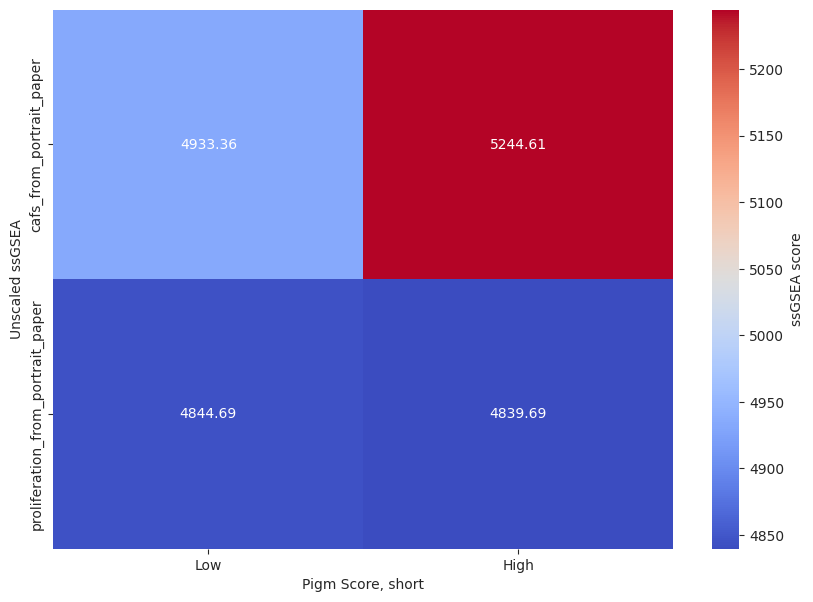

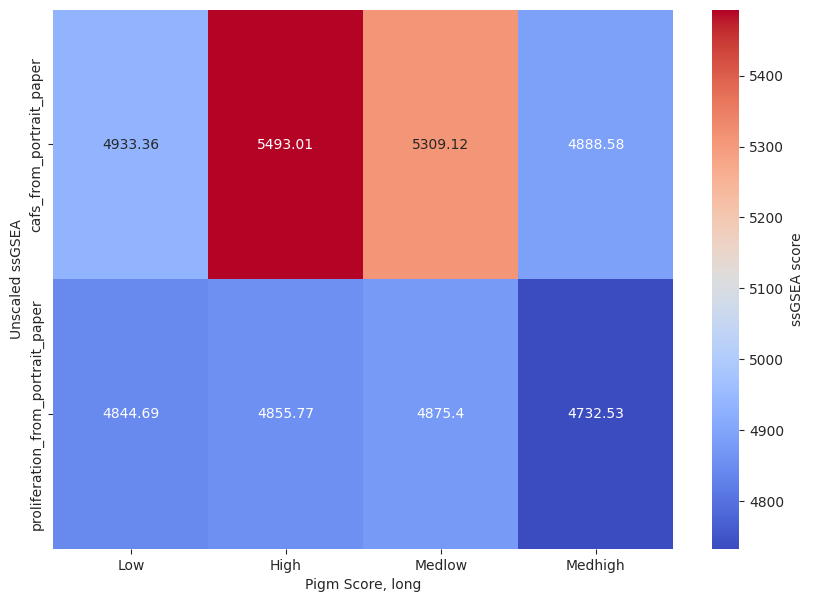

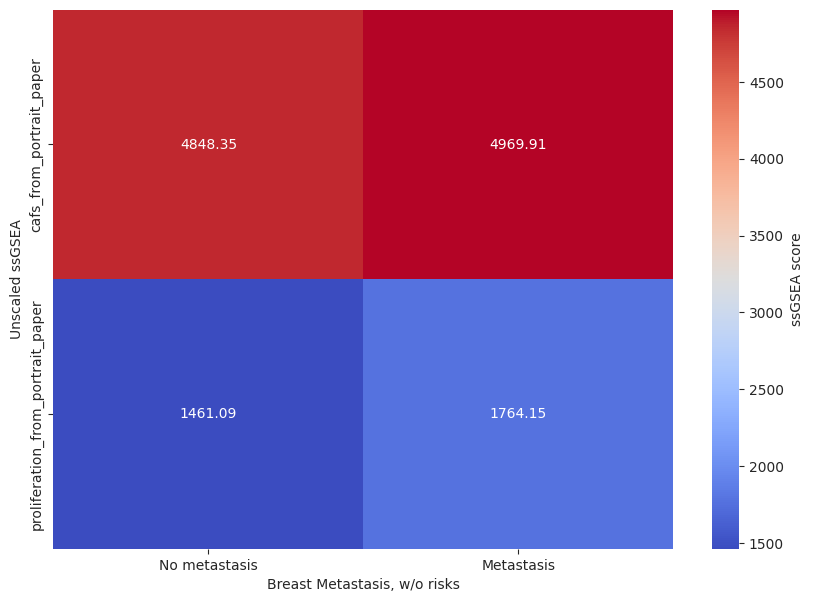

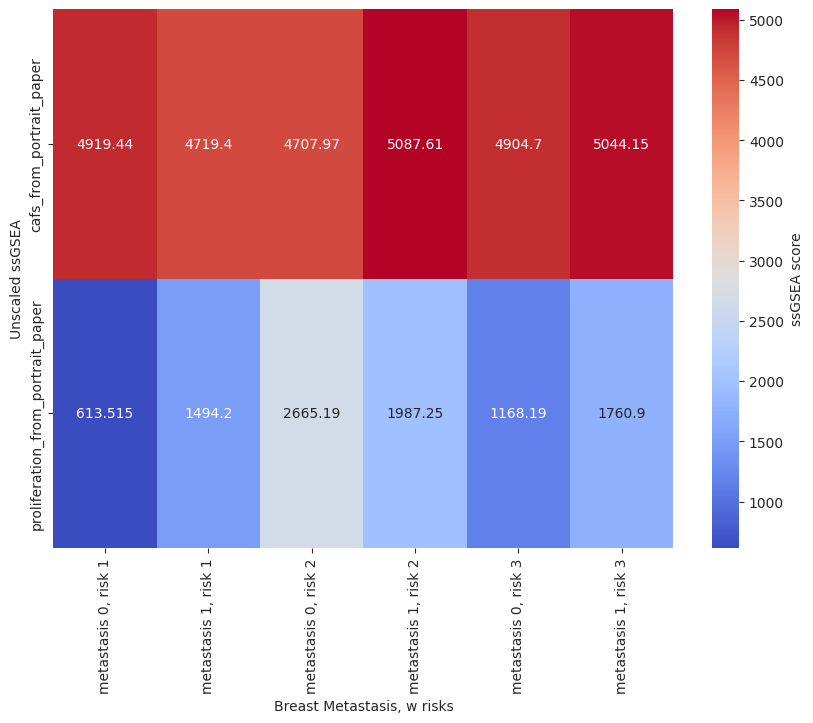

In [ ]:
for col in cols:
    x = pd.DataFrame(tables[col]).dropna().T
    #     x_sc = x.copy()
    #     x_sc = x_sc/x_sc.sum()
    #     x_sc = x_sc.T/x_sc.T.sum()
    #     x_sc = x_sc.T
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(
        x, annot=x, cmap="coolwarm", fmt="g", ax=ax, cbar_kws={"label": "ssGSEA score"}
    )
    ax.set_xlabel(col)
    ax.set_ylabel("Unscaled ssGSEA")

## Waterfall plot

In [ ]:
# c = 'Breast Metastasis, w risks'
c = "Pigm Score, short"
x = pd.DataFrame(tables[c]).dropna().T
x_std = pd.DataFrame(tables_stdev[c]).dropna().T
x

,Low,High
BG EMT FGES,2499.443902,2065.011567
BG SKCM-EMT FGES,1457.611103,259.737117
Hallmark EMT FGES,4351.985483,4328.256173
BG Metastasis FGES,5864.574848,5588.914699
"Metastasis FGES, Ramaswamy et al.",7625.862666,7614.432542
"Metastasis FGES, Landemaine et al.",-162.100630,-711.457179
"Metastasis FGES, Albini et al.",4446.942639,4481.688573


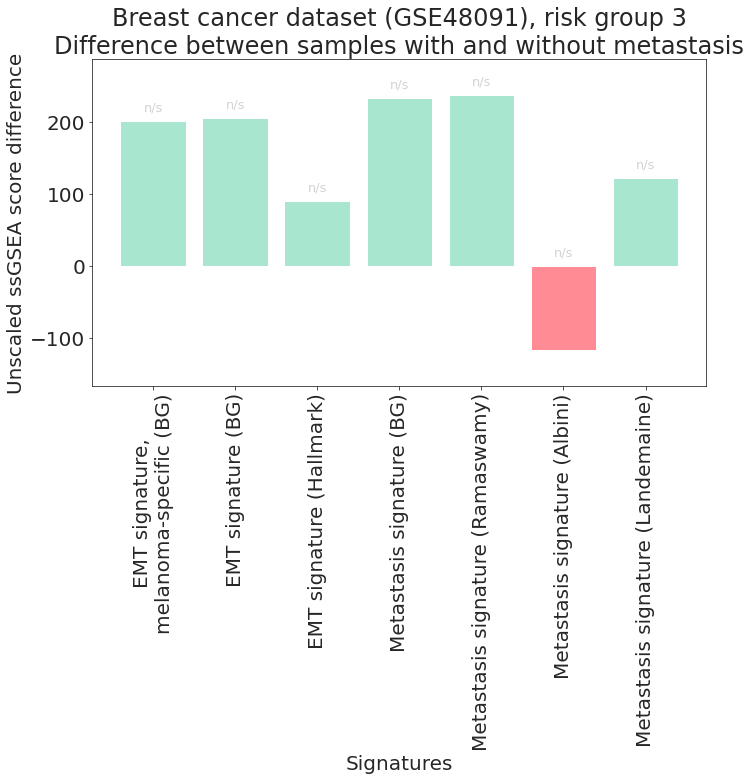

In [ ]:
out = {sign: {} for sign in emt_gmt.keys()}
for sign in emt_gmt.keys():
    out[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .mean(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .mean(),
    }
    out[sign]["Pigm Score, long"] = {
        "Low": df_pigm[sign].reindex(pigm_long[pigm_long == 0].index).dropna().mean(),
        "Medlow": df_pigm[sign]
        .reindex(pigm_long[pigm_long == 1].index)
        .dropna()
        .mean(),
        "Medhigh": df_pigm[sign]
        .reindex(pigm_long[pigm_long == 2].index)
        .dropna()
        .mean(),
        "High": df_pigm[sign].reindex(pigm_long[pigm_long == 3].index).dropna().mean(),
    }
    out[sign]["Breast Metastasis, w/o risks"] = {
        "No metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 0].index)
        .dropna()
        .mean(),
        "Metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 1].index)
        .dropna()
        .mean(),
    }
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    out[sign]["Breast Metastasis, w risks"] = {
        x: df_br[sign].reindex(ser[ser == x].index).dropna().mean()
        for x in [
            "metastasis 0, risk 1",
            "metastasis 1, risk 1",
            "metastasis 0, risk 2",
            "metastasis 1, risk 2",
            "metastasis 0, risk 3",
            "metastasis 1, risk 3",
        ]
    }

pd.DataFrame(out[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    "Pigm Score, long",
    "Breast Metastasis, w/o risks",
    "Breast Metastasis, w risks",
]
tables = {col: {sign: None for sign in out.keys()} for col in cols}
for sign in out.keys():
    for col in cols:
        tables[col][sign] = pd.DataFrame(out[sign])[col]
out_stdev = {sign: {} for sign in emt_gmt.keys()}
for sign in emt_gmt.keys():
    out_stdev[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .std(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .std(),
    }
    out_stdev[sign]["Pigm Score, long"] = {
        "Low": df_pigm[sign].reindex(pigm_long[pigm_long == 0].index).dropna().std(),
        "Medlow": df_pigm[sign].reindex(pigm_long[pigm_long == 1].index).dropna().std(),
        "Medhigh": df_pigm[sign]
        .reindex(pigm_long[pigm_long == 2].index)
        .dropna()
        .std(),
        "High": df_pigm[sign].reindex(pigm_long[pigm_long == 3].index).dropna().std(),
    }
    out_stdev[sign]["Breast Metastasis, w/o risks"] = {
        "No metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 0].index)
        .dropna()
        .std(),
        "Metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 1].index)
        .dropna()
        .std(),
    }
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    out_stdev[sign]["Breast Metastasis, w risks"] = {
        x: df_br[sign].reindex(ser[ser == x].index).dropna().std()
        for x in [
            "metastasis 0, risk 1",
            "metastasis 1, risk 1",
            "metastasis 0, risk 2",
            "metastasis 1, risk 2",
            "metastasis 0, risk 3",
            "metastasis 1, risk 3",
        ]
    }
pd.DataFrame(out_stdev[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    "Pigm Score, long",
    "Breast Metastasis, w/o risks",
    "Breast Metastasis, w risks",
]
tables_stdev = {col: {sign: None for sign in out_stdev.keys()} for col in cols}
for sign in out_stdev.keys():
    for col in cols:
        tables_stdev[col][sign] = pd.DataFrame(out_stdev[sign])[col]

out_mw = {sign: {} for sign in emt_gmt.keys()}
for sign in emt_gmt.keys():
    _, pv = mannwhitneyu(
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna(),
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna(),
        alternative="two-sided",
    )
    out_mw[sign]["Pigm Score, short"] = pv
    _, pv = mannwhitneyu(
        df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 1].index)
        .dropna(),
        df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 0].index)
        .dropna(),
        alternative="two-sided",
    )
    out_mw[sign]["Breast Metastasis, w/o risks"] = pv

    riskgroup = 3
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    a = (
        df_br[sign]
        .reindex(ser[ser == f"metastasis 0, risk {riskgroup}"].index)
        .dropna()
    )
    b = (
        df_br[sign]
        .reindex(ser[ser == f"metastasis 1, risk {riskgroup}"].index)
        .dropna()
    )
    _, pv = mannwhitneyu(a, b, alternative="two-sided")
    out_mw[sign]["Breast Metastasis, w risks"] = pv
out_mw = pd.DataFrame(out_mw)
for i in out_mw.index:
    _, out_mw.loc[i], _, _ = multipletests(out_mw.loc[i], method="fdr_bh")
c = "Breast Metastasis, w risks"
# c = 'Pigm Score, short'
x = pd.DataFrame(tables[c]).dropna().T
x_std = pd.DataFrame(tables_stdev[c]).dropna().T


plt.rcParams["svg.fonttype"] = "none"
dif = x[f"metastasis 1, risk {riskgroup}"] - x[f"metastasis 0, risk {riskgroup}"]
# dif = x['Metastasis']-x['No metastasis']
# dif = x['Low']-x['High']
dif = dif.sort_values(ascending=False)
# dif = dif.reindex(['Main4_EMT_signature_SKCM_old',
#        'Main4_EMT_signature_old',  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Landemaine_BRCA_Lung_Met_UP','Main4_Metastasis_SOLID',
#        'Ramaswamy_Met_Up',
#        'Albini_Met_UP'])
dif = dif.reindex(
    [
        "BG SKCM-EMT FGES",
        "BG EMT FGES",
        "Hallmark EMT FGES",
        "BG Metastasis FGES",
        "Metastasis FGES, Ramaswamy et al.",
        "Metastasis FGES, Landemaine et al.",
        "Metastasis FGES, Albini et al.",
    ]
)

sns.set_style("ticks")
plt.rcParams.update({"font.size": 20})
# dif = pd.Series({sign:tn_ss_sc[sign][tn_labels_short=='cancer'].mean()-tn_ss_sc[sign][tn_labels_short=='normal'].mean() for sign in tn_ss_sc.columns})
p = []
for d in dif.index:
    if dif.loc[d] > 0:
        p.append("#a8e6cf")
    else:
        p.append("#ff8b94")
fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(np.arange(0, len(dif.index)), dif, color=p)
plt.xticks([i for i in range(len(dif.index))])
ax.set_xticklabels(
    labels=[
        "EMT signature,\nmelanoma-specific (BG)",
        "EMT signature (BG)",
        "EMT signature (Hallmark)",
        "Metastasis signature (BG)",
        "Metastasis signature (Ramaswamy)",
        "Metastasis signature (Albini)",
        "Metastasis signature (Landemaine)",
    ],
    rotation=90,
)
ax.set_xlabel("Signatures")

ax.set_ylabel("Unscaled ssGSEA score difference")
ax.set_title(
    f"Breast cancer dataset (GSE48091), risk group {riskgroup}\nDifference between samples with and without metastasis"
)
# ax.set_ylabel('Unscaled ssGSEA score difference\nbetween Low and High')
# ax.set_title('TCGA pigmentation annotation\nDifference between low and high pigment score')
# ax.set_ylabel('Scaled ssGSEA score difference\nbetween Cancerous and Normal tissue')
# ax.set_title('Tumor-normal datasets, short\nDifference between Cancerous and Normal tissue')
for d in range(len(dif.index)):
    pv = out_mw.loc[c].loc[dif.index[d]]
    if pv <= 0.05:
        #         pv = 'p-value: {:0.1e}'.format(pv)
        if pv <= 0.001:
            pv = "***"
        elif pv <= 0.01:
            pv = "**"
        else:
            pv = "*"
    else:
        #         pv = 'p-value: {}'.format(round(pv,2))
        pv = "n/s"
    if dif.iloc[d] < 0:
        y = 10
    else:
        y = dif.iloc[d] + 10
    if pv != "n/s":
        ax.annotate(pv, (d, y), ha="center", va="center", size=17, c="dimgray")
    else:
        ax.annotate(pv, (d, y), ha="center", va="bottom", size=13, c="lightgray")
    plt.ylim(dif.min() - 50, dif.max() + 50)
    # plt.savefig(f"/home/nlukashevich/Chess_projects/Signature_validation_paper/Figures/Pigmentation_EMT_signatures_waterfall.svg", format="svg")

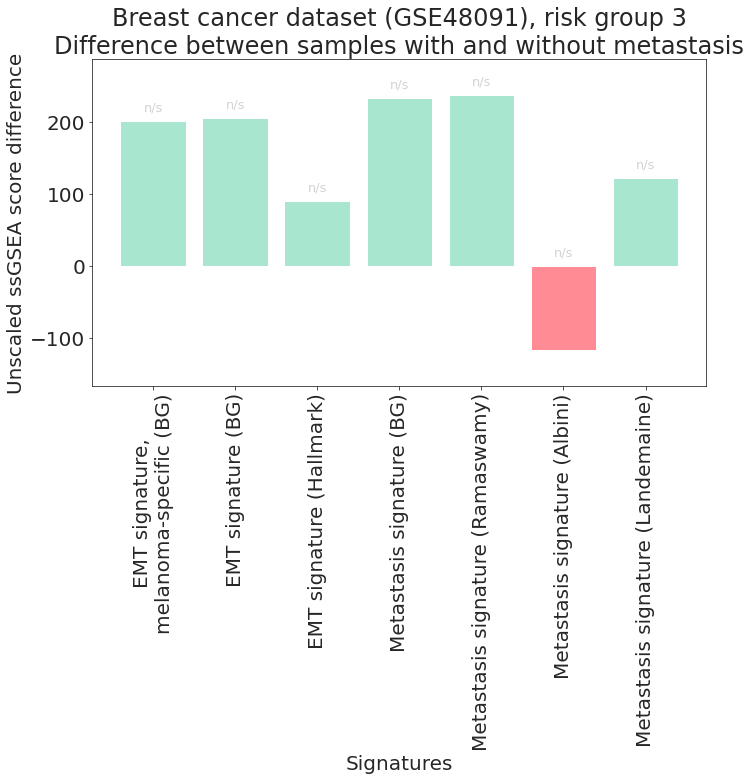

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
dif = x[f"metastasis 1, risk {riskgroup}"] - x[f"metastasis 0, risk {riskgroup}"]
# dif = x['Metastasis']-x['No metastasis']
# dif = x['Low']-x['High']
dif = dif.sort_values(ascending=False)
# dif = dif.reindex(['Main4_EMT_signature_SKCM_old',
#        'Main4_EMT_signature_old',  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Landemaine_BRCA_Lung_Met_UP','Main4_Metastasis_SOLID',
#        'Ramaswamy_Met_Up',
#        'Albini_Met_UP'])
dif = dif.reindex(
    [
        "BG SKCM-EMT FGES",
        "BG EMT FGES",
        "Hallmark EMT FGES",
        "BG Metastasis FGES",
        "Metastasis FGES, Ramaswamy et al.",
        "Metastasis FGES, Landemaine et al.",
        "Metastasis FGES, Albini et al.",
    ]
)

sns.set_style("ticks")
plt.rcParams.update({"font.size": 20})
# dif = pd.Series({sign:tn_ss_sc[sign][tn_labels_short=='cancer'].mean()-tn_ss_sc[sign][tn_labels_short=='normal'].mean() for sign in tn_ss_sc.columns})
p = []
for d in dif.index:
    if dif.loc[d] > 0:
        p.append("#a8e6cf")
    else:
        p.append("#ff8b94")
fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(np.arange(0, len(dif.index)), dif, color=p)
plt.xticks([i for i in range(len(dif.index))])
ax.set_xticklabels(
    labels=[
        "EMT signature,\nmelanoma-specific (BG)",
        "EMT signature (BG)",
        "EMT signature (Hallmark)",
        "Metastasis signature (BG)",
        "Metastasis signature (Ramaswamy)",
        "Metastasis signature (Albini)",
        "Metastasis signature (Landemaine)",
    ],
    rotation=90,
)
ax.set_xlabel("Signatures")

ax.set_ylabel("Unscaled ssGSEA score difference")
ax.set_title(
    f"Breast cancer dataset (GSE48091), risk group {riskgroup}\nDifference between samples with and without metastasis"
)
# ax.set_ylabel('Unscaled ssGSEA score difference\nbetween Low and High')
# ax.set_title('TCGA pigmentation annotation\nDifference between low and high pigment score')
# ax.set_ylabel('Scaled ssGSEA score difference\nbetween Cancerous and Normal tissue')
# ax.set_title('Tumor-normal datasets, short\nDifference between Cancerous and Normal tissue')
for d in range(len(dif.index)):
    pv = out_mw.loc[c].loc[dif.index[d]]
    if pv <= 0.05:
        #         pv = 'p-value: {:0.1e}'.format(pv)
        if pv <= 0.001:
            pv = "***"
        elif pv <= 0.01:
            pv = "**"
        else:
            pv = "*"
    else:
        #         pv = 'p-value: {}'.format(round(pv,2))
        pv = "n/s"
    if dif.iloc[d] < 0:
        y = 10
    else:
        y = dif.iloc[d] + 10
    if pv != "n/s":
        ax.annotate(pv, (d, y), ha="center", va="center", size=17, c="dimgray")
    else:
        ax.annotate(pv, (d, y), ha="center", va="bottom", size=13, c="lightgray")
    plt.ylim(dif.min() - 50, dif.max() + 50)
    # plt.savefig(f"/home/nlukashevich/Chess_projects/Signature_validation_paper/Figures/Pigmentation_EMT_signatures_waterfall.svg", format="svg")

## Patch heatmap

In [ ]:
h = "High_Pigment"
l = "Low_Pigment"
df = df_pigm_sc
labs = pigm["Pigmentation_Score"]

# h = 'cancer'
# l = 'normal'
# df = tn_ss_sc
# labs = tn_labels_short

# h = 'metastasis'
# l = 'no metastasis'
# met = anno_br['metastasis_status']
# met[met==0] = l
# met[met==1] = h
# df = df_br_sc
# labs = met

names = df.groupby(labs[labs.isin([h, l])]).median().T
for c in names.columns:
    names[c] = names[c].map(lambda x: f"{round(x, 2)}")
names

Pigmentation_Score,High_Pigment,Low_Pigment
Main4_EMT_signature,-0.03,0.17
Main4_EMT_signature_SKCM,0.25,0.11
EMT_mel_NL,0.03,0.2
Main4_EMT_signature_SKCM_old,-0.16,0.29
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.28,0.12
Main4_Metastasis_SOLID,-0.03,0.12
Ramaswamy_Met_Up,-0.13,-0.04
Landemaine_BRCA_Lung_Met_UP,-0.22,0.29
Albini_Met_UP,0.2,0.03


In [ ]:
scs = df.groupby(labs[labs.isin([h, l])]).mean().T
scs = pd.DataFrame(
    index=scs.columns,
    columns=scs.index,
    data=np.array(pd.concat([scs[i] for i in scs.columns]).rank(pct=True)).reshape(
        names.shape[1], names.shape[0]
    ),
).T
sps = {sign: {h: None, l: None} for sign in df.columns}
for sign in df.columns:
    x = df[sign].reindex(labs[labs == h].index).dropna()
    y = df[sign].reindex(labs[labs == l].index).dropna()
    _, pv = mannwhitneyu(x, y)
    if x.mean() > y.mean() and pv <= 0.05:
        sps[sign][h] = pv
        sps[sign][l] = -pv
    elif x.mean() < y.mean() and pv <= 0.05:
        sps[sign][l] = pv
        sps[sign][h] = -pv
    else:
        sps[sign][l] = pv
        sps[sign][h] = pv
    print(sign, pv)
sps = pd.DataFrame(sps)
_, fdr, _, _ = multipletests(
    pd.concat([abs(sps.loc[i]) for i in sps.index]), method="fdr_bh"
)
sps = pd.DataFrame(
    index=sps.index,
    columns=sps.columns,
    data=np.array(
        fdr
        * pd.concat([sps.loc[i] for i in sps.index])
        / abs(pd.concat([sps.loc[i] for i in sps.index]))
    ).reshape(names.shape[1], names.shape[0]),
)
sps = sps.T

Main4_EMT_signature 0.15669271945694446
Main4_EMT_signature_SKCM 0.9107816080914007
EMT_mel_NL 0.0034406037789107744
Main4_EMT_signature_SKCM_old 9.143087031621014e-06
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.7664149919426162
Main4_Metastasis_SOLID 0.009737666983429163
Ramaswamy_Met_Up 0.5394241217039133
Landemaine_BRCA_Lung_Met_UP 2.9092286429943422e-05
Albini_Met_UP 0.5282910265043501


In [ ]:
for c in sps.columns:
    if len(sps[c][abs(sps[c]) > 0.05][sps[c] < 0].index) > 0:
        for i in sps[c][abs(sps[c]) > 0.05][sps[c] < 0].index:
            sps.at[i, c] = abs(sps.loc[i][c])

In [ ]:
for c in sps.columns:
    sps[c][sps[c] > 0.05] = 1
    sps[c][sps[c] < 0] = -1
    sps[c][~sps[c].isin([-1, 1])] = 0
sps

,High_Pigment,Low_Pigment
Main4_EMT_signature,1.0,1.0
Main4_EMT_signature_SKCM,1.0,1.0
EMT_mel_NL,-1.0,0.0
Main4_EMT_signature_SKCM_old,-1.0,0.0
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1.0,1.0
Main4_Metastasis_SOLID,-1.0,0.0
Ramaswamy_Met_Up,1.0,1.0
Landemaine_BRCA_Lung_Met_UP,-1.0,0.0
Albini_Met_UP,1.0,1.0


In [ ]:
common = {}
common["breast"] = dict(sps=sps, scs=scs, names=names)
common["tn"] = dict(sps=sps, scs=scs, names=names)
common["mel"] = dict(sps=sps, scs=scs, names=names)
sps = pd.concat([common[i]["sps"] for i in common.keys()], axis=1)
scs = pd.concat([common[i]["scs"] for i in common.keys()], axis=1)
names = pd.concat([common[i]["names"] for i in common.keys()], axis=1)

In [ ]:
sps[sps == -1] = -20
sps[sps == 1] = 20

In [939]:
df

,x,y,names,pvalues,size
0,Main4_EMT_signature,metastasis,0.06,20.0,11.111111
1,Main4_EMT_signature_SKCM,metastasis,0.2,0.0,18.888889
2,EMT_mel_NL,metastasis,0.13,0.0,12.222222
3,Main4_EMT_signature_SKCM_old,metastasis,0.15,0.0,17.777778
4,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,metastasis,0.15,0.0,13.333333
5,Main4_Metastasis_SOLID,metastasis,0.17,0.0,14.444444
6,Ramaswamy_Met_Up,metastasis,0.11,0.0,8.888889
7,Landemaine_BRCA_Lung_Met_UP,metastasis,-0.08,-20.0,15.555556
8,Albini_Met_UP,metastasis,0.15,0.0,16.666667
9,Main4_EMT_signature,no metastasis,-0.08,20.0,10.000000
